<a href="https://colab.research.google.com/github/sp-au-mu-nl/SpeechComm/blob/main/notebook/chap11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/data/chap11.zip
!unzip -o chap11.zip
!rm chap11.zip

--2025-04-23 10:47:39--  https://github.com/sp-au-mu-nl/SpeechComm/raw/refs/heads/main/data/chap11.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/data/chap11.zip [following]
--2025-04-23 10:47:40--  https://raw.githubusercontent.com/sp-au-mu-nl/SpeechComm/refs/heads/main/data/chap11.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1181073 (1.1M) [application/zip]
Saving to: ‘chap11.zip’

chap11.zip          100%[===================>]   1.13M  --.-KB/s    in 0.04s   

2025-04-23 10:47:40 (25.1 MB/s) - ‘chap11.zip’ saved [1181073/1181073]

Archive:  c

In [2]:
!pip install git+https://github.com/javanasse/worldvocoder
!pip install dtw-python

  Cloning https://github.com/javanasse/worldvocoder to /tmp/pip-req-build-6e7sxjou
  Running command git clone --filter=blob:none --quiet https://github.com/javanasse/worldvocoder /tmp/pip-req-build-6e7sxjou
  Resolved https://github.com/javanasse/worldvocoder to commit 99866822bd471c9386d769d05d2d2c7b966976e0
  Preparing metadata (setup.py) ... done
  Created wheel for worldvocoder: filename=worldvocoder-0.0.1-py3-none-any.whl size=41227 sha256=f8894033a36c9dffe73ee541cf0dc9cc14e4ef902f4e87c1491142c73211901c
  Stored in directory: /tmp/pip-ephem-wheel-cache-asc02m2k/wheels/a2/f0/cf/47f6dee1f6d791c2ed9a3af33faabf909b4d4330111fecae10
Successfully built worldvocoder
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.7/801.7 kB 18.1 MB/s eta 0:00:00


In [3]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.1 MB/s eta 0:00:00


プログラム 11.1

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import worldvocoder as wv
import librosa
import IPython

import dtw

import plotly.graph_objects as go
import plotly.express as px

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
yAiueo, sr = librosa.load('boin8k.wav', sr=None)
go.Figure(go.Scatter(y=yAiueo, mode='lines+markers'))

In [6]:
pA = yAiueo[7075:7125]
fo = sr/len(pA)
print('fo = ', fo)
durSyllable = 0.5
nPeriod = int(fo*durSyllable)
IPython.display.Audio(np.tile(pA, nPeriod), rate=sr)

fo =  160.0


In [7]:
foLow = 120
nLow = int(sr/foLow)
IPython.display.Audio(np.tile(np.hstack((pA,
                                         np.zeros(nLow-len(pA)))),
                              int(foLow*durSyllable)), rate=sr)

In [8]:
pI = yAiueo[15043:15090]
nVowel = max(len(pA),len(pI))
durTrans = 0.1
nPeriodTrans = int(sr*durTrans/nVowel)
unitA = np.hstack((pA.T, np.zeros(nVowel-len(pA))))
unitA = unitA/np.max(np.abs(unitA))
unitI = np.hstack((pI.T, np.zeros(nVowel-len(pI))))
unitI = unitI/np.max(np.abs(unitI))
down = np.linspace(1, 0, nVowel*nPeriodTrans)
up = np.linspace(0, 1, nVowel*nPeriodTrans)
ySynthAI = np.hstack((np.tile(unitA, nPeriod-nPeriodTrans),
                     np.tile(unitA, nPeriodTrans)*down
                      + np.tile(unitI, nPeriodTrans)*up,
                     np.tile(unitI, nPeriod-nPeriodTrans)))
IPython.display.Audio(ySynthAI, rate=sr)

In [9]:
yKa, _ = librosa.load('ka48k.wav', sr=sr)
go.Figure(go.Scatter(y=yKa, mode='lines+markers'))
yKa = yKa/np.max(np.abs(yKa))
pK = yKa[500:1204]
downC = np.linspace(1, 0, nVowel)
upC = np.linspace(0, 1, nVowel)
ySynthKa = np.hstack((pK[:len(pK)-nVowel],
                     pK[-nVowel:]*downC + unitA*upC,
                     np.tile(unitA, nPeriod-nVowel)))
IPython.display.Audio(ySynthKa, rate=sr)

プログラム 11.2

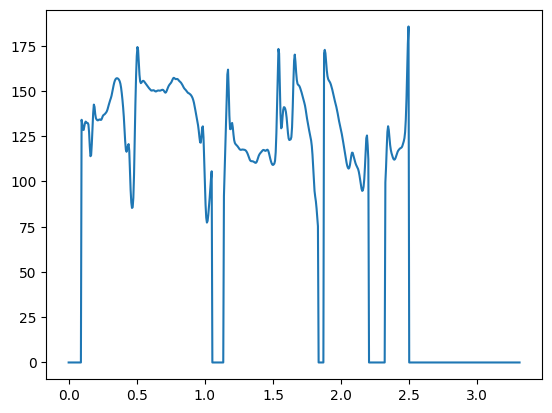

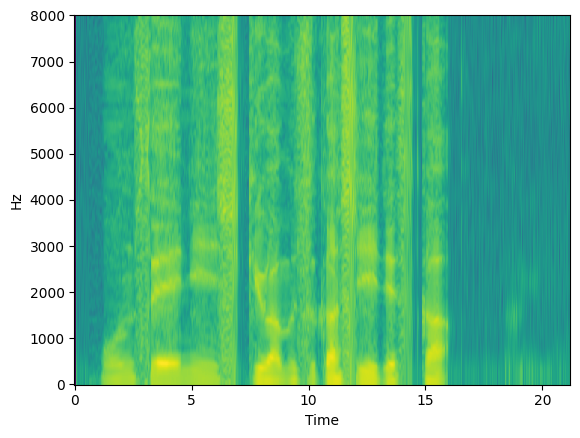

In [10]:
y1, fs1 = librosa.load('ja_sentence.wav', sr=None)
vocoder = wv.World()

feature1 = vocoder.encode(fs1, y1, f0_method='harvest')
plt.plot(feature1['temporal_positions'], feature1['f0'])
fig = plt.gcf()
fig.savefig('fig11_01.eps')
plt.figure()
librosa.display.specshow(20*np.log10(feature1['spectrogram']),
                         cmap='viridis', sr=fs1, x_axis='time',
                         y_axis='linear')
output1 = vocoder.decode(feature1)
IPython.display.Audio(output1['out'], rate=fs1)

プログラム 11.3

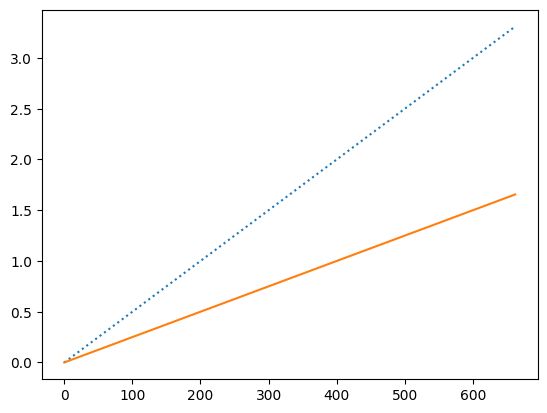

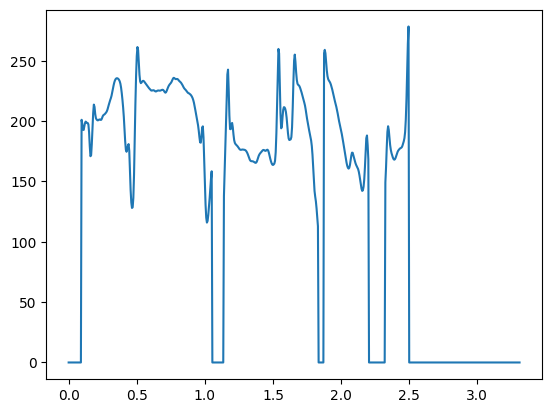

In [11]:
feature1_1 = copy.deepcopy(feature1)
feature1_1 = vocoder.scale_duration(feature1_1, 0.5)
output1_1 = vocoder.decode(feature1_1)
IPython.display.display(IPython.display.Audio(output1_1['out'],
                                              rate=fs1))
plt.plot(feature1['temporal_positions'],':')
plt.plot(feature1_1['temporal_positions'])

feature1_2 = copy.deepcopy(feature1)
feature1_2 = vocoder.scale_pitch(feature1_2, 1.5)
output1_2 = vocoder.decode(feature1_2)
plt.figure()
plt.plot(feature1_2['temporal_positions'], feature1_2['f0'])
IPython.display.Audio(output1_2['out'], rate=fs1)

プログラム 11.4

<ipython-input-12-59c671c6795c>:5: RuntimeWarning:

divide by zero encountered in log2



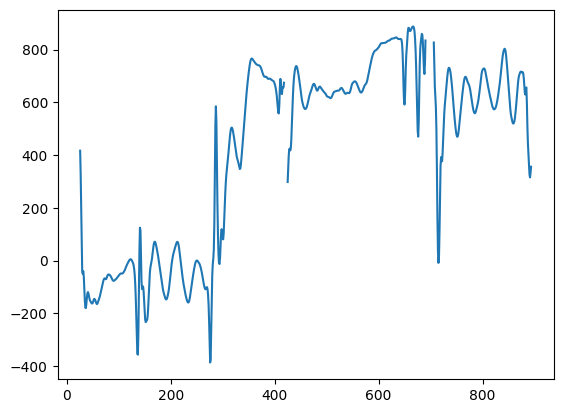

In [12]:
y2, fs2 = librosa.load('twinkle.wav')

feature2 = vocoder.encode(fs2, y2, f0_method='harvest')
c4 = 261.6
plt.plot(1200*np.log2(feature2['f0']/c4))

feature2_1 = copy.deepcopy(feature2)
feature2_1['f0'][34:280] = feature2_1['f0'][34:280]*2**(80/1200);
feature2_1['f0'][345:569] = feature2_1['f0'][345:569]*2**(70/1200);
feature2_1['f0'][588:708] = feature2_1['f0'][588:708]*2**(100/1200);
feature2_1['f0'][729:883] = feature2_1['f0'][729:883]*2**(70/1200);
output2_1 = vocoder.decode(feature2_1)
IPython.display.Audio(output2_1['out'], rate=fs2)

プログラム 11.5

<ipython-input-13-ff6e833078de>:6: RuntimeWarning:

divide by zero encountered in log2

<ipython-input-13-ff6e833078de>:13: RuntimeWarning:

divide by zero encountered in log2



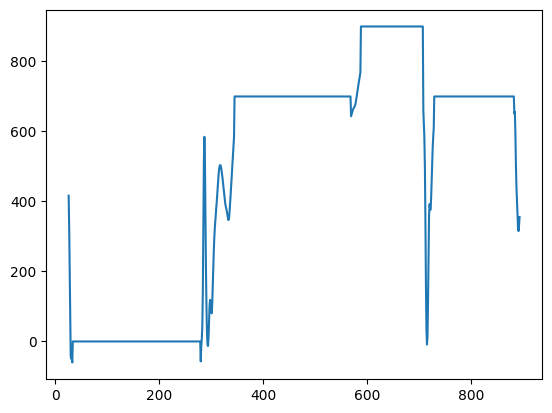

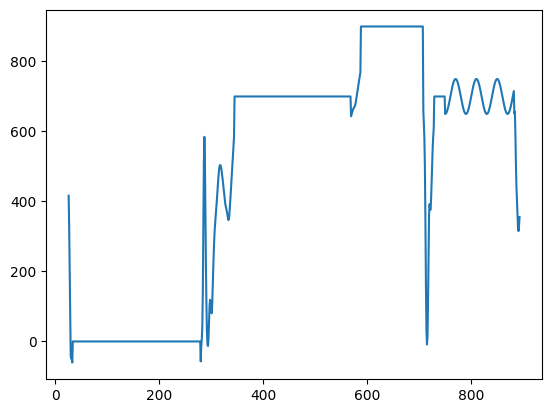

In [13]:
feature2_2 = copy.deepcopy(feature2)
feature2_2['f0'][34:280] = c4;
feature2_2['f0'][345:569] = c4*2**(7/12);
feature2_2['f0'][588:708] = c4*2**(9/12);
feature2_2['f0'][729:883] = c4*2**(7/12);
plt.plot(1200*np.log2(feature2_2['f0']/c4))
ext = 2**(0.5/12)
rate = 5
feature2_2['f0'][750:883] = c4*(2**
 (7/12))*(ext**np.sin(2*np.pi*rate*
                      feature2_2['temporal_positions'][750:883]))
plt.figure()
plt.plot(1200*np.log2(feature2_2['f0']/c4))
output2_2 = vocoder.decode(feature2_2)
IPython.display.Audio(output2_2['out'], rate=fs2)

プログラム 11.6

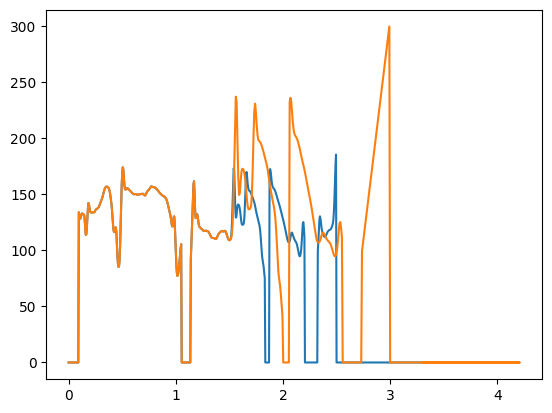

In [14]:
feature1_4 = copy.deepcopy(feature1)
s1 = 300; e1 = 410
feature1_4['f0'][s1:e1] = 2*feature1_4['f0'][s1:e1] -\
  feature1_4['f0'][s1]
feature1_4['f0'][feature1_4['f0']<0] = 0
s2 = 465; e2 = 500
feature1_4['f0'][s2:e2] = np.linspace(feature1_4['f0'][s2],300,e2-s2)
ts1 = feature1_4['temporal_positions'][s1]
feature1_4['temporal_positions'][s1:-1] = 1.5*\
feature1_4['temporal_positions'][s1:-1] - 0.5*ts1
plt.plot(feature1['temporal_positions'], feature1['f0'])
plt.plot(feature1_4['temporal_positions'], feature1_4['f0'])
feature1_4['spectrogram'] = feature1['spectrogram']*\
np.tile(np.linspace(1,4,feature1_4['spectrogram'].shape[1])**2,
 (feature1_4['spectrogram'].shape[0],1))
output1_4 = vocoder.decode(feature1_4)
IPython.display.Audio(output1_4['out'], rate=fs1)

プログラム 11.7

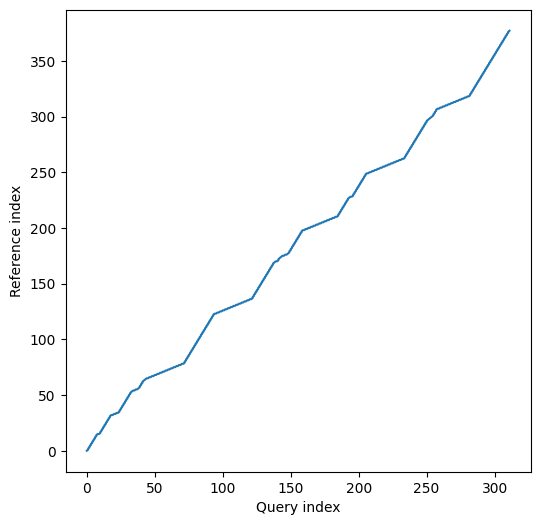

In [15]:
fs3 = 16000
ys1, _ = librosa.load('ja_intonation_original.wav', sr=fs3)
ys2, _ = librosa.load('common_voice_ja_24976975.mp3', sr=fs3)
fig = px.line(ys1); fig.show()
fig = px.line(ys2); fig.show()
ys1 = ys1[1800:32000]
ys2 = ys2[9050:34000]
nFFT = 1024; nShift = 80; nMels = 40; nMFCC = 13
feature3_s1 = vocoder.encode(fs3, ys1, f0_method='harvest',
                             fft_size=nFFT)
feature3_s2 = vocoder.encode(fs3, ys2, f0_method='harvest',
                             fft_size=nFFT)
mfcc_s1 = librosa.feature.mfcc(y=ys1, hop_length=nShift, sr=fs3,
                             n_fft=nFFT, window=np.hanning(nFFT),
                             n_mels=nMels, n_mfcc=nMFCC)
mfcc_s2 = librosa.feature.mfcc(y=ys2, hop_length=nShift, sr=fs3,
                             n_fft=nFFT, window=np.hanning(nFFT),
                             n_mels=nMels, n_mfcc=nMFCC)
alignment = dtw.dtw(mfcc_s2.T, mfcc_s1.T, keep_internals=True,
    step_pattern=dtw.rabinerJuangStepPattern(2, "c")) # (6, "c")
alignment.plot()

tSpec = np.zeros(feature3_s1['spectrogram'].shape)
#tAperiod = np.zeros(feature3_s1['aperiodicity'].shape)
for idx in np.unique(alignment.index2):
  tSpec[:,idx] = np.mean(feature3_s2['spectrogram']
   [:,alignment.index1[alignment.index2==idx]],axis=1)
feature_t = copy.deepcopy(feature3_s1)
feature_t['spectrogram'] = tSpec
#feature_t['aperiodicity'] = tAperiod
foS1 = np.sum(feature3_s1['f0'])/np.sum(feature3_s1['f0']>0)
foS2 = np.sum(feature3_s2['f0'])/np.sum(feature3_s2['f0']>0)
feature_t = vocoder.scale_pitch(feature_t, foS2/foS1)
output_t = vocoder.decode(feature_t)
IPython.display.Audio(output_t['out'], rate=fs3)